In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE, SelectFromModel
from collections import Counter
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed
from boruta import BorutaPy
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

import random



C:\Users\KRR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read and Encode test data

In [2]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
#df = df.sample(n=2000, replace=False, random_state=42)

model = SentenceTransformer("all-MiniLM-L6-v2")  
text_embeddings = model.encode(df["text"].astype(str).tolist(), convert_to_numpy=True)
df["text"] = text_embeddings.mean(axis=1)  
screen_name_embeddings = model.encode(df["screen_name"].astype(str).tolist(), convert_to_numpy=True)
df["screen_name"] = screen_name_embeddings.mean(axis=1)  

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [3]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)


GBC using all features of the dataset

In [4]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

preds = gbc.predict(X_test)
probs = gbc.predict_proba(X_test)[:, 1]  

f1_score_all = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
auc_score_all = round(roc_auc_score(y_test, probs), 6)

# Print results
print(f"F1 Score: {f1_score_all}")
print(f"AUC Score: {auc_score_all}")


F1 Score: 0.946718
AUC Score: 0.649133


Variance Treshold Method

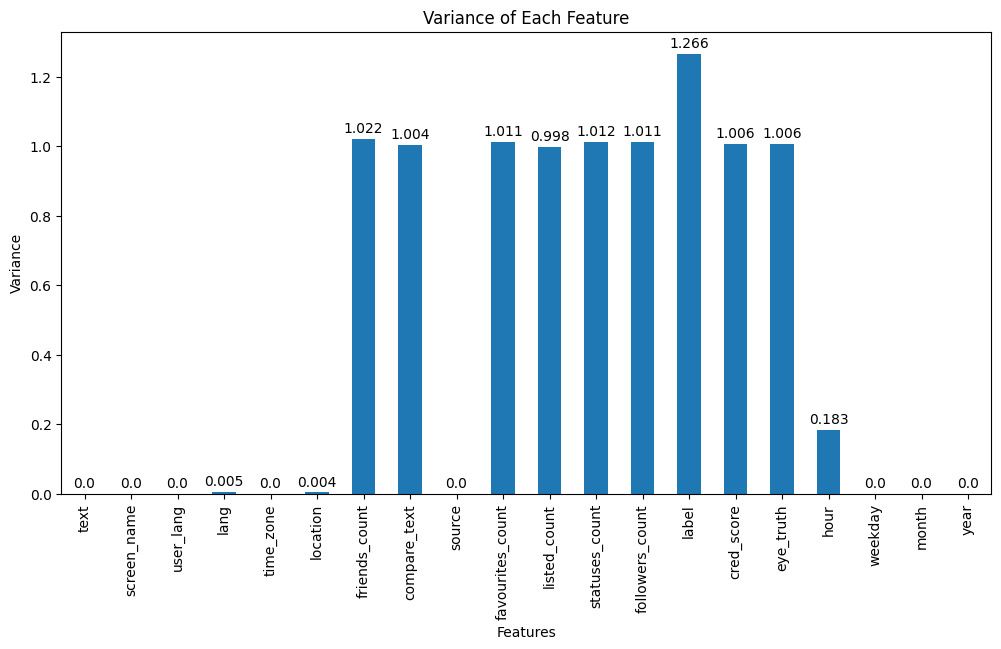

In [5]:
X_train_V, X_test_V, y_train_V, y_test_V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

Dropping Features with variance below 0.8

In [6]:
sel_X_train = X_train_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
sel_X_test = X_test_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)
f1_score = round(f1_score(y_test, preds, average='weighted'), 3)
probs = gbc.predict_proba(X_test)[:, 1]  
auc_score = round(roc_auc_score(y_test, probs), 3)

print(f"F1 Score: {f1_score}")
print(f"AUC Score: {auc_score}")

F1 Score: 0.947
AUC Score: 0.649


SelectKbest feature selection (filter)

In [11]:
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def evaluate_kbest(k, X_train_V1, y_train_V1, X_test_V1, y_test_V1):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_V1, y_train_V1)

    selected_X_train = selector.transform(X_train_V1)
    selected_X_test = selector.transform(X_test_V1)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(selected_X_train, y_train_V1)
    
    kbest_preds = gbc.predict(selected_X_test)
    kbest_probs = gbc.predict_proba(selected_X_test)[:, 1] 

    f1_score_kbest = round(f1_score(y_test_V1, kbest_preds, average='weighted'), 3)
    auc_score_kbest = round(roc_auc_score(y_test_V1, kbest_probs), 3)

    return f1_score_kbest, auc_score_kbest, k


results = Parallel(n_jobs=-1)(delayed(evaluate_kbest)(k, X_train_V1, y_train_V1, X_test_V1, y_test_V1) for k in range(1, 21))

f1_score_list, auc_score_list, feature_counts = zip(*results)

selected_features_dict = {}
for k in range(1, 21):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_V1, y_train_V1)
    selected_features_mask = selector.get_support()
    selected_features_dict[k] = list(X_train_V1.columns[selected_features_mask])

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947)
AUC Scores: (np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.506), np.float64(0.5), np.float64(0.518), np.float64(0.509), np.float64(0.629), np.float64(0.638), np.float64(0.637), np.float64(0.639), np.float64(0.64), np.float64(0.643), np.float64(0.645), np.float64(0.643), np.float64(0.645), np.float64(0.642), np.float64(0.642), np.float64(0.648), np.float64(0.649))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


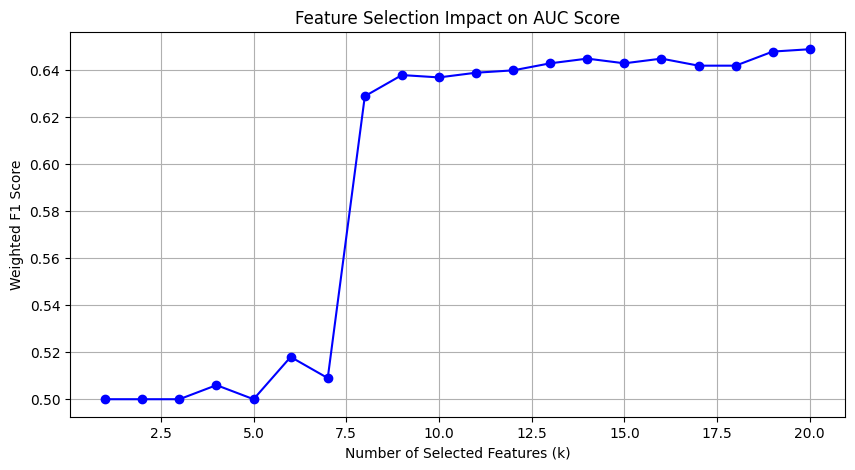

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, auc_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("Feature Selection Impact on AUC Score")
plt.grid(True)
plt.show()

Recursive Feature Elimination (Wrapper)

In [13]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

gbc = GradientBoostingClassifier(random_state=42)

def evaluate_rfe(k, X_train_V2, y_train_V2, X_test_V2, y_test_V2):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_V2, y_train_V2)

    sel_X_train_V2 = RFE_selector.transform(X_train_V2)
    sel_X_test_V2 = RFE_selector.transform(X_test_V2)

    selected_features = np.where(RFE_selector.support_)[0]
    
    gbc.fit(sel_X_train_V2, y_train_V2)
    RFE_preds = gbc.predict(sel_X_test_V2)
    f1_score_RFE = round(f1_score(y_test_V2, RFE_preds, average="weighted"), 3)


    RFE_probs = gbc.predict_proba(sel_X_test_V2)[:, 1]  
    auc_score_RFE = round(roc_auc_score(y_test_V2, RFE_probs), 3)

    return f1_score_RFE, auc_score_RFE, k, selected_features

results = Parallel(n_jobs=-1)(delayed(evaluate_rfe)(k, X_train_V2, y_train_V2, X_test_V2, y_test_V2) for k in range(1, 21))

f1_score_list, auc_score_list, feature_counts, selected_features_list = zip(*results)

selected_features_dict = {}
for k, features in zip(range(1, 21), selected_features_list):
    selected_features_dict[k] = features

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947)
AUC Scores: (np.float64(0.516), np.float64(0.632), np.float64(0.635), np.float64(0.642), np.float64(0.639), np.float64(0.64), np.float64(0.641), np.float64(0.642), np.float64(0.646), np.float64(0.651), np.float64(0.648), np.float64(0.648), np.float64(0.648), np.float64(0.646), np.float64(0.646), np.float64(0.646), np.float64(0.645), np.float64(0.645), np.float64(0.646), np.float64(0.649))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


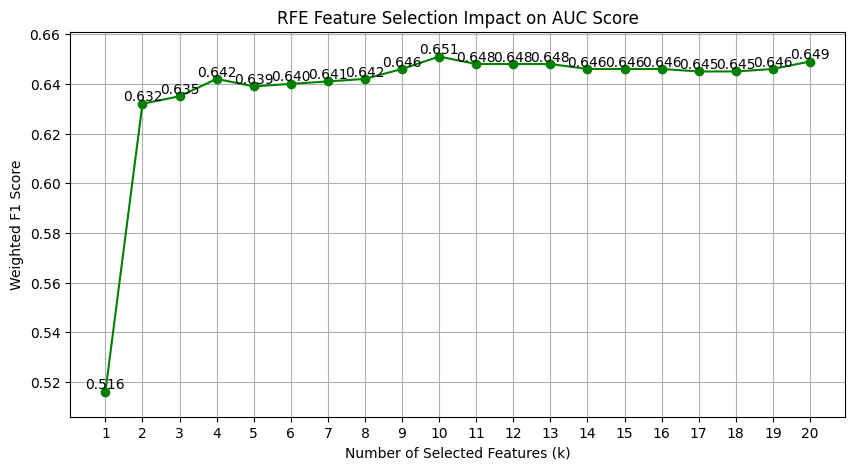

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), auc_score_list, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("RFE Feature Selection Impact on AUC Score")
plt.xticks(range(1, 21))
plt.ylim(min(auc_score_list) - 0.01, max(auc_score_list) + 0.01)
plt.grid(True)

for i, score in enumerate(auc_score_list, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()


Embedded Method

In [7]:
gbc = GradientBoostingClassifier(random_state=42)
boruta = BorutaPy(gbc, n_estimators='auto', random_state=42)
boruta.fit(X_train.values, y_train)
selected_features = boruta.support_


X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

gbc.fit(X_train_selected, y_train)
preds = gbc.predict(X_test_selected)
probs = gbc.predict_proba(X_test_selected)[:, 1]

f1_score_all = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
auc_score_all = round(roc_auc_score(y_test, probs), 6)

print(f"F1 Score: {f1_score_all}")
print(f"AUC Score: {auc_score_all}")

selected_feature_names = X_train.columns[selected_features]
print(f"Selected Features: {selected_feature_names}")

F1 Score: 0.94642
AUC Score: 0.633772
Selected Features: Index(['friends_count', 'eye_truth'], dtype='object')


C:\Users\KRR\AppData\Local\Temp\ipykernel_96524\1390321558.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


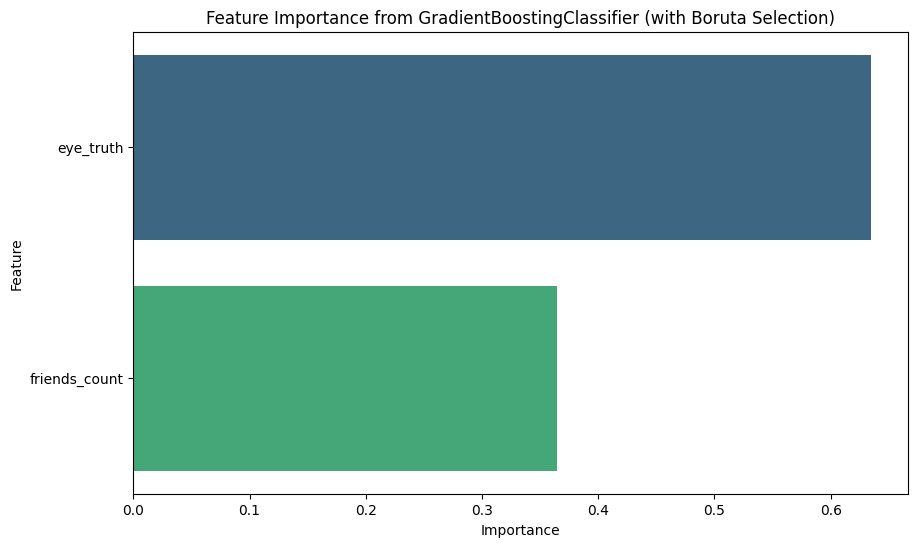

In [8]:
# Get feature import from trained gbc
importances = gbc.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Sort by import
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from GradientBoostingClassifier (with Boruta Selection)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Binary PSO Method 2: Multiclass Classification

In [ ]:

class BinaryPSOWithMutation:
    def __init__(self, X_train, X_test, y_train, y_test, num_particles=10, max_iter=20, mutation_rate=0.1, num_folds=5):
        self.X_train = X_train  
        self.X_test = X_test    
        self.y_train = y_train
        self.y_test = y_test
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = X_train.shape[1]
        self.mutation_rate = mutation_rate
        self.num_folds = num_folds 
        self.particles = np.random.randint(0, 2, (self.num_particles, self.num_features))  
        self.best_particle = None
        self.best_score = -1

    def fitness(self, particle):
        selected_features = np.where(particle == 1)[0]
        if len(selected_features) == 0:
            return 0, 0 

        # select features from datafram
        X_train_fs = self.X_train.iloc[:, selected_features]
        y_train_fs = self.y_train
        
        # smote for oversampling minority class
        smote = SMOTE(random_state=42)
        X_train_fs, y_train_fs = smote.fit_resample(X_train_fs, y_train_fs)

        # initialise Stratified KFold
        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        auc_scores = []
        accuracy_scores = []

        # perform cross-validation
        for train_index, val_index in skf.split(X_train_fs, y_train_fs):
            X_fold_train, X_fold_val = X_train_fs.iloc[train_index], X_train_fs.iloc[val_index]
            y_fold_train, y_fold_val = y_train_fs.iloc[train_index], y_train_fs.iloc[val_index]

            # inntialize gbc
            model = GradientBoostingClassifier(random_state=42)
            model.fit(X_fold_train, y_fold_train)

            # get predictions and compute metrics
            y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
            auc_score = roc_auc_score(y_fold_val, y_pred_proba)
            accuracy = accuracy_score(y_fold_val, model.predict(X_fold_val))

            auc_scores.append(auc_score)
            accuracy_scores.append(accuracy)

        avg_auc = np.mean(auc_scores)
        avg_accuracy = np.mean(accuracy_scores)

        return avg_auc, avg_accuracy

    def mutate(self, particle):
        # Randomly flip bits in particle based on mutation rate
        mutation_mask = np.random.rand(self.num_features) < self.mutation_rate
        particle[mutation_mask] = 1 - particle[mutation_mask]
        return particle

    def optimize(self):
        best_accuracy = -1
        
        for iter_num in range(self.max_iter):
            for i in range(self.num_particles):
                mutated_particle = self.mutate(self.particles[i])
                auc_score, accuracy = self.fitness(mutated_particle)

                if auc_score > self.best_score:
                    self.best_score = auc_score
                    self.best_particle = mutated_particle.copy()
                    best_accuracy = accuracy

                # PSO update parameters
                A = 2 * np.random.rand() - 1  # exploration factor
                C = 2 * np.random.rand()      # convergence factor
                p = np.random.rand()
                l = np.random.uniform(-1, 1)  # spiral parameter

                if p < 0.5:
                    if abs(A) < 1:
                        self.particles[i] = self.best_particle + A * (self.best_particle - self.particles[i])
                    else:
                        rand_particle = self.particles[np.random.randint(0, self.num_particles)]
                        D = abs(C * rand_particle - self.particles[i])
                        self.particles[i] = rand_particle - A * D
                else:
                    D = abs(self.best_particle - self.particles[i])
                    self.particles[i] = D * np.exp(l) * np.cos(2 * np.pi * l) + self.best_particle

                # ensure  updated particle remains binary
                self.particles[i] = np.clip(self.particles[i], 0, 1)
                self.particles[i] = (self.particles[i] > 0.5).astype(int)

        selected_features = np.where(self.best_particle == 1)[0]
        return selected_features, self.best_score, best_accuracy

# Step 4: Run  Binary PSO Optimization
#b_pso = BinaryPSOWithMutation(X_train, X_test, y_train, y_test, num_particles=5, max_iter=5, mutation_rate=0.1, num_folds=3) #untested but should reduce runn time
b_pso = BinaryPSOWithMutation(X_train, X_test, y_train, y_test, num_particles=5, max_iter=10, mutation_rate=0.1, num_folds=3) #this took 44 mins 

best_features, best_auc, best_accuracy = b_pso.optimize()

print(f"Selected Features: {best_features}")
print(f"Best AUC Score: {best_auc}")
print(f"Best Accuracy: {best_accuracy}")


Selected Features: [ 1  2  6  8 10 11 14 18]
Best AUC Score: 0.9716654382911009
Best Accuracy: 0.9266532205455073


GSFO Algorithm

In [ ]:

class GreySailFishOptimization:
    def __init__(self, X_train, X_test, y_train, y_test, n_particles=30, max_iter=100, mutation_rate=0.1, w1=0.5, w2=0.5):
        
        self.X_train = X_train      
        self.X_test = X_test       
        self.y_train = y_train      
        self.y_test = y_test
        self.n_features = X_train.shape[1]
        self.n_particles = n_particles      
        self.max_iter = max_iter            
        self.mutation_rate = mutation_rate  
        self.w1 = w1  # weight for auc
        self.w2 = w2  # weight for accuracy

        # intialize particles (binary feature masks) and velocities
        self.positions = np.random.randint(0, 2, (self.n_particles, self.n_features))
        self.velocities = np.random.rand(self.n_particles, self.n_features)
        self.best_positions = np.copy(self.positions)
        self.best_scores = np.zeros(self.n_particles)
        self.global_best_position = None
        self.global_best_score = float('-inf')

    def fitness_function(self, position):

        selected_features = np.where(position == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0  

        # select features from dataframe
        X = self.X_train.iloc[:, selected_features]
        y = self.y_train

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        auc_scores = []
        accuracy_scores = []
        smote = SMOTE(random_state=42)

        for train_idx, val_idx in skf.split(X, y):
            X_fold_train = X.iloc[train_idx]
            X_fold_val = X.iloc[val_idx]
            y_fold_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
            y_fold_val = y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]

            #  smote to balance  training fold
            X_fold_train, y_fold_train = smote.fit_resample(X_fold_train, y_fold_train)

            # gbc instead of decision tree
            clf = GradientBoostingClassifier(random_state=42)
            clf.fit(X_fold_train, y_fold_train)

            y_pred_proba = clf.predict_proba(X_fold_val)[:, 1]
            auc = roc_auc_score(y_fold_val, y_pred_proba)
            y_pred = clf.predict(X_fold_val)
            acc = accuracy_score(y_fold_val, y_pred)

            auc_scores.append(auc)
            accuracy_scores.append(acc)

        avg_auc = np.mean(auc_scores)
        avg_acc = np.mean(accuracy_scores)
        fitness = self.w1 * avg_auc + self.w2 * avg_acc

        return fitness, avg_auc, avg_acc

    def update_position(self, i):
    
        #Updates particle position i using a hybrid GSFO/GWO update rule.
        alpha = 2 * np.random.rand() - 1  # influence of best solution
        beta = 2 * np.random.rand() - 1   # influence of secondary solution
        delta = 2 * np.random.rand() - 1  # additional spiral parameter

        sailfish_position = self.best_positions[i]
        rand_particle = self.positions[random.randint(0, self.n_particles - 1)]
        # sfo-inspired update of velocity and position
        self.velocities[i] = self.velocities[i] + alpha * (self.best_positions[i] - self.positions[i]) \
                             + beta * (sailfish_position - self.positions[i])
        self.positions[i] = np.clip(self.positions[i] + self.velocities[i], 0, 1)
        # gwo-inspired update to enhance exploration
        self.positions[i] = self.positions[i] * np.exp(delta) * np.cos(2 * np.pi * delta) + self.best_positions[i]

        self.mutation(i)

    def mutation(self, i):
        #applies mutation to particle i.
        mutation_mask = np.random.rand(self.n_features) < self.mutation_rate
        self.positions[i][mutation_mask] = 1 - self.positions[i][mutation_mask]

    def optimize(self):
    
        #runs  GSFO optimization - print each iter progress 
        #return  best feature subset (as indices), the best fitness score, best avg AUC, best avg  accuracy
        
        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                fitness, auc_score, accuracy = self.fitness_function(self.positions[i])
                self.best_scores[i] = fitness

                if fitness > self.global_best_score:
                    self.global_best_score = fitness
                    self.global_best_position = self.positions[i].copy()
                    self.global_best_auc = auc_score
                    self.global_best_accuracy = accuracy

                self.update_position(i)

            print(f"Iteration {iteration+1}/{self.max_iter} - Best Fitness: {self.global_best_score:.4f} | " f"Best AUC: {self.global_best_auc:.4f} | Best Accuracy: {self.global_best_accuracy:.4f}")

        best_feature_indices = np.where(self.global_best_position == 1)[0]
        return best_feature_indices, self.global_best_score, self.global_best_auc, self.global_best_accuracy

#gsfo = GreySailFishOptimization(X_train, X_test, y_train, y_test,  n_particles=10, max_iter=20, mutation_rate=0.1) -- this takes over 26mins

gsfo = GreySailFishOptimization(X_train, X_test, y_train, y_test,  n_particles=5, max_iter=5, mutation_rate=0.1)

best_features, best_score, best_auc, best_accuracy = gsfo.optimize()

print("Selected Features:", best_features)
print("Best Fitness Score (weighted AUC + Accuracy):", best_score)
print("Best AUC:", best_auc)
print("Best Accuracy:", best_accuracy)


Iteration 1/5 - Best Fitness: 0.7882 | Best AUC: 0.6162 | Best Accuracy: 0.9601
Iteration 2/5 - Best Fitness: 0.7882 | Best AUC: 0.6162 | Best Accuracy: 0.9601
Iteration 3/5 - Best Fitness: 0.7882 | Best AUC: 0.6146 | Best Accuracy: 0.9618
Iteration 4/5 - Best Fitness: 0.7882 | Best AUC: 0.6146 | Best Accuracy: 0.9618
Iteration 5/5 - Best Fitness: 0.7923 | Best AUC: 0.6210 | Best Accuracy: 0.9636
Selected Features: [ 2  5  6  9 11 12 14 15 16 18 19]
Best Fitness Score (weighted AUC + Accuracy): 0.7923241984047406
Best AUC: 0.6210246914405634
Best Accuracy: 0.9636237053689177
